# Assignment 4

This assignment is meant to exercise you on **Spark** and understanding of **Finding Similar Items** and **Clustering**.

To receive credit, answer all questions correctly and submit to Canvas before the deadline.

**This assignment is due Sunday, Dec 12 at 11:59 PM.**

**YOUR FULL NAME (1 POINT)**: SANKALP SINGH RATHORE

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignment with others, please **include their names** below.

**Collaborators**: *list collaborators here*

In [27]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Part 1: Spark (19 points)

In the classroom, we have learned how to write a word count task in Spark using notebook. Please feel free to use the example as a reference to finish this task.

Now you will write your first Spark job to accomplish the following task:

1. Outputs the number of words that start with each letter (i.e., 52 letters as A, B, C, ... Z, and a, b, c, ..., z). This means that for every letter we want to count the total number of (non-unique) words that start with that letter. **Example: every occurrence of 'Apple2019' as a word should contribute 1 count to letter A.**

1. Run your program over the same input data pg100.txt as in the classroom and output the result as a dataframe similarly as the example shown in class.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt-get update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 198 kB 48.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=31adad2dcba8d37b89a3de22412fd40ee748cffbb65bf90219bf62d08262c43f
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://develope

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1SE6k_0YukzGd5wK-E4i6mG83nydlfvSa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('pg100.txt')

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [ ]:
import re #regular expression used to split lines of text into words

lines = sc.textFile("./pg100.txt")

#Split the lines into words (including all alphanumeric characters)
words = lines.flatMap(lambda line: re.split(r'[^\w]+', line))

#Mapper
words=words.distinct()
letters = words.filter(lambda letter: letter.isalpha())\
                  .map(lambda word: word[0])                  
pairs = words.map(lambda word: (word, 1))
             

pairs = letters.map(lambda letters: (letters, 1))
counts = pairs.reduceByKey(lambda n1, n2: n1 + n2)
counts.toDF().toPandas()


,_1,_2
0,S,923
1,i,725
2,r,1081
3,g,678
4,C,773
5,c,2004
6,J,98
7,O,157
8,W,316
9,p,1679


# Part 2: Finding Similar Items (18 points)

Considering the following matrix representation of four documents (i.e., C1, C2, C3, and C4), fill the corresponding hash value for both h1 and h2 (i.e., replacing '-' with the corresponding hash value).

|Row(i.e., x) | C1 | C2 | C3 | C4 | h1(x) = (2x+1) mod 5  | h2(x) = (3x+1) mod 5 |
| --- | --- | --- | --- | --- | --- | --- |
|1|1|0|0|1|3|4|
|2|0|0|1|0|0|2|
|3|0|1|0|1|2|0|
|4|1|0|1|1|4|3|
|5|0|0|1|0|1|1|

Then, provide the signature matrix format of these four documents after applying those two hash functions in the following (i.e., replacing '-' with the corresponding signature).

|C1|C2|C3|C4|
|---|---|---|---|
|3|2|0|2|
|3|0|1|0|

# Part 3: Clustering

This part will help you understand the details of implementing k-means both in a traditional way and in Spark (Optional: BONUS POINTS). In addition, this part will also help you understand the impact of using different distance metrics and initialization strategies in practice.

## Part 3.1: Introduction

Let us say we have a set $X$ of $n$ data points in the $d$-dimensional space (i.e., $d$ features). Given the number of clusters $k$ and the set of $k$ centroids $C$, we now proceed to define various distance metrics and the corresponding cost functions that they minimize in clustering.

### 3.1.1 Euclidean Distance

Given two points $A$ and $B$ in $d$ dimensional space such that $A = [a_1, a_2, \cdots, a_d]$ and $B = [b_1, b_2, \cdots, b_d]$, the Euclidean distance between $A$ and $B$ is defined as

\begin{equation}
||A-B||=\sqrt{\sum_{i=1}^d (a_i-b_i)^2}
\end{equation}

The corresponding cost function $\phi$ that is minimized when we assign points to clusters using the Euclidean distance metric is given by [**NOTE: Pay attention to the square**]

\begin{equation}
\phi = \sum_{x\in X} \min_{c\in C}||x-c||^2
\end{equation}


### 3.1.2 Manhattan distance

The Manhattan distance between $A$ and $B$ is defined as

\begin{equation}
|A-B| = \sum_{i=1}^d|a_i-b_i|
\end{equation}

The corresponding cost function $\psi$ that is minimized when we assign points to clusters using the Manhattan distance metric is given by

\begin{equation}
\psi =\sum_{x\in X}\min_{c\in C}|x-c|
\end{equation}

### 3.1.3 Iterative K-Means Algorithm 

We learned the basic k-means algorithm in class which is as follows: $k$ centroids are initialized, each point is assigned to the nearest centroid and the centroids are recomputed based on the assignments of points to clusters. In practice, the above steps are run for several iterations. We present the resulting iterative version of k-means in Algorithm 1.

--------------------------------------------------------

Algorithm 1: Iterative K-Means Algorithm

1. Select $k$ points as initial centroids of the $k$ clusters.

2. for iterations 1 to MAX_ITER do
  * for each point $p$ in the dataset do
      * Assign point $p$ to the cluster with the closest centroid
  * end for
  * for each cluster $c$ do
    * Recompute the centroid of $c$ as the mean of all the data points assigned to $c$
  * end for
3. end for

---------------------------------------------------------

### 3.1.4 Data and Setup

Please use the dataset in kmeans.zip downloaded from Canvas of A4.

The zip has 3 files:

    1. data.txt contains the dataset which has 4601 rows and 58 columns. Each row is a document represented as a 58 dimensional vector of features. Each component in the vector represents the importance of a word in the document.

    2. c1.txt contains k initial cluster centroids. These centroids were chosen by selecting k = 10 random points from the input data.

    3. c2.txt contains initial cluster centroids which are as far apart as possible using 'Euclidean distance' (i.e., k-means++).

Set number of iterations MAX_ITER=25 and number of clusters $k=10$ for all the following experiments. **Your program should ensure that the correct number of iterations are run.**

## Part 3.2: Exploring initialization strategies with Euclidean distance

In this part, you are expected to implement the traditional k-means (small-scale version) using the Euclidean distance. **Note: you should implement k-means according to the above introduction by yourself (i.e., not using existing k-means lib), while you may use python lib for Euclidean distance calculation. There is no constrains on how you implement. Pay close attention on how cost should be calculated.** 

#### Question 3.2.1 [18 points]

Using the Euclidean distance as the distance measure, compute the cost function $\phi(i)$ for every iteration $i$.

For the first iteration, you will be computing the cost function using the initial centroids located in one of the two text files. 

Run your k-means on data.txt using c1.txt and c2.txt separately. Generate a graph where you plot the cost as the number of iterations increases for both c1.txt and c2.txt (e.g., two lines in one graph). 

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class. The expected plot is provided in A4 folder of Canvas for your self-checking.**

In [ ]:
import pandas as pd
import numpy as np
datapd= pd.read_csv("/data.txt",header=None,delimiter=" ")
c1pd= pd.read_csv("/c1.txt",header=None,delimiter=" ")
c2pd= pd.read_csv("/c2.txt",header=None,delimiter=" ")
c1=c1pd.to_numpy()
c2=c2pd.to_numpy()
data=datapd.to_numpy()

In [ ]:
#creating the K means Algorithm
def K_MEANS(k,MAXITER,C,distance):
  xaxis=[]
  yaxis=[]
  for iter in range(0,MAXITER):
    costeuc=[]
    cluster=[]
    for i in data:
      x=np.zeros(0)
      #distance calulation
      if (distance=="euclidean"):
        for j in C:
          distance_euc=np.sqrt(np.sum((i-j)**2))
          x=np.append(x,distance_euc)
        costeuc.append(np.amin(x)**2)
      elif(distance=="manhattan"):
        for j in C:
          distance_man=np.sum(np.abs(i-j))
          x=np.append(x,distance_man)
        costeuc.append(np.amin(x))
       #finding the index of cluster with the minimum distance  
      index=np.where(x==np.amin(x))
      cluster=np.append(cluster,index[0][0])
    cluster=cluster.astype(int)
    newcentroid=np.empty(shape=C.shape)
    #updating the centroid by finding the sum and average
    for i in range(data.shape[0]):
      newcentroid[cluster[i]]+=data[i]
    unique, counts = np.unique(cluster, return_counts=True)
    for i in range(k):
      newcentroid[i]=newcentroid[i]/counts[i]
    C=newcentroid
    xaxis.append(iter)
    #calcualting the total sum
    yaxis.append(np.sum(costeuc))
  return xaxis,yaxis

In [ ]:
x1,y1=K_MEANS(10,25,c1,"euclidean")
x2,y2=K_MEANS(10,25,c2,"euclidean")

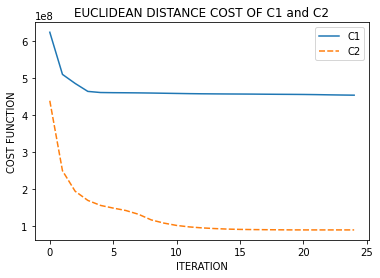

In [ ]:
import seaborn as sns
d={'C1':y1,'C2':y2}
costplot=pd.DataFrame(d)
ax=sns.lineplot(data=costplot)
ax.set(xlabel='ITERATION', ylabel='COST FUNCTION', title="EUCLIDEAN DISTANCE COST OF C1 and C2")
print(" ")

### Question 3.2.2 [3 points]

Looking at the cost after 10 iterations, is random initialization of k-means using c1.txt better than initialization using c2.txt? Explain your reasoning on why.

After 10 iterations we can see that the cost of iterations for centroid found with k means is less than the cost of iterations for centroid found using random method and so we can say that the Centroid found by k means are better.

## Part 3.3: Exploring initialization strategies with Manhattan distance



### Question 3.3.1 [9 points]

Similar to Question 3.2.1, using the Manhattan distance as the distance measure, compute the cost function $\psi(i)$ for every iteration $i$.

For the first iteration, you will be computing the cost function using the initial centroids located in one of the two text files. 

Run your k-means on data.txt using c1.txt and c2.txt separately. Generate a graph where you plot the cost as the number of iterations increases for both c1.txt and c2.txt (e.g., two lines in one graph).

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class. The expected plot is provided in A4 folder of Canvas for your self-checking.**

In [ ]:
x3,y3=K_MEANS(10,25,c1,"manhattan")
x4,y4=K_MEANS(10,25,c2,"manhattan")

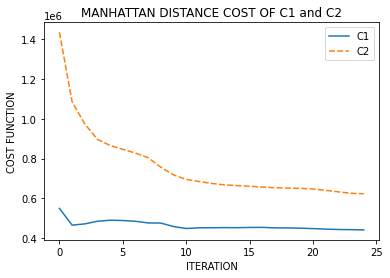

In [ ]:
#plotting the cost vs iteration
d={'C1':y3,'C2':y4}
costplot=pd.DataFrame(d)
ax=sns.lineplot(data=costplot)
ax.set(xlabel='ITERATION', ylabel='COST FUNCTION', title="MANHATTAN DISTANCE COST OF C1 and C2")
print(" ")


### Question 3.3.2 [3 points]

Looking at the cost after 10 iterations, is random initialization of k-means using c1.txt better than initialization using c2.txt? Explain your reasoning on why.

After 10 iterations the random initialisation of k means using C1 is better than C2 as the total cost for manhattan distance for c1 is much lower than c2 

## Part 3.4 [BONUS: OPTIONAL]: K-Means using MapReduce in Spark (+20 points)

This is an optional part. You will implement k-means using MapReduce in Spark when the data is stored in multiple machines. You may use the following steps as a reference for your implementation.

1. Setup Spark environment as the Spark Example in Lecture. You may define a `SparkContext` as `sc`.

2. Use `sc.textFile()` to load data (data.txt) and both initializations (c1.txt and c2.txt) separately. [HINT: `sc.textFile()` will load data line by line as a string, you may apply `Map` to each line to split those values using space and store them as numerical values in `np.array`]

3. Centroids of c1 and c2 should be collected (`.collect()`) for each Mapper since they are small, while data should not.

4. Use `Map` to assign each data point in each Mapper to the nearest centroid. The cost of each data point can be added using `Map` immediately after the assignment.

5. Use `Reduce` to recompute new centroids that should be collected (`.collect()`) again. [HINT: `Reduce` may calculate the sum of all data points assigned to the same cluster (i.e., the same key). Another 'Map' may be used to calculate the average]

### Question 3.4.1 [+20 points]

Implement Spark k-means using the Euclidean distance as the distance measure, compute the cost function $\phi(i)$ for every iteration $i$ of data.txt for both c1.txt and c2.txt and plot. The plot is expected to be same as Question 3.2.1.

**Your visualization should be easy to follow considering those techniques of visualization we discussed in class.**

In [3]:
!pip install pyspark
!pip install -U -q PyDrive
!apt-get update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 64.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=d832b3e728e8bbe6a008ba7f73a9b62e305b63d6a66cfc62479430db93149501
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release


In [17]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext,SparkConf
import numpy as np


In [60]:
conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)
data1 = sc.textFile("/data.txt").map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).cache()

c1 = sc.textFile("/c1.txt").map(lambda line: np.array([float(x) for x in line.split(' ')])).collect()
c2 = sc.textFile("/c2.txt").map(lambda line: np.array([float(x) for x in line.split(' ')])).collect()

In [64]:

MAX_ITER=25
def closest(p, centroids):
    
    
    cluster=[]
    x=[]
    for j in centroids:
      distance_euc=np.sqrt(np.sum((p-j)**2))
      x=np.append(x,distance_euc)
    cost=np.amin(x)      
    index=np.where(x==cost)
    cluster=np.append(cluster,index[0][0])
    cluster=cluster.astype(int)
    return cluster[0]

In [65]:
def cost_calculation(p,c):
    return np.sum((p-c)**2)

In [63]:
def kmeans(data, centroids):
    total_cost = []
    
    for t in range(1,MAX_ITER+1):
        
       
        combo = data.map(lambda point: (closest(point, centroids), (point, 1))).cache()
        
        #calcualte the cost
        cost = combo.map(lambda x :(t,cost_calculation(x[1][0],centroids[x[0]])) ) 
        #sum the total cost
        cost_sum=cost.reduceByKey(lambda x,y:x+y)
        total_cost.append(cost_sum.collect()[0][1])
        #calculate the next centroid
        sum_rdd=combo.reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1]))
        new_centroid = sum_rdd.mapValues(lambda x:x[0]/x[1])
        temp=new_centroid.collect()
        for i in range(10):
          centroids[i]=temp[i][1]
            
    return total_cost

In [62]:
cost1 = kmeans(data1, c1)
cost2 = kmeans(data1, c2)
sc.stop()

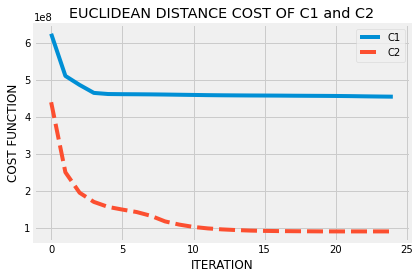

In [54]:

d={'C1':cost1,'C2':cost2}
costplot=pd.DataFrame(d)
ax=sns.lineplot(data=costplot)
ax.set(xlabel='ITERATION', ylabel='COST FUNCTION', title="EUCLIDEAN DISTANCE COST OF C1 and C2")
print(" ")

# Submission

Make sure you have run all cells in your notebook in order, so that all images/graphs appear in the output. 
1. Under 'File' tab to Print as PDF
2. Download ipynb 
3. Submit both PDF and ipynb to Canvas (NOT zip)